# Tanzania Water Well Classification Project: Does it Need Repair?

## **About**

#### The purpose of this notebook is to share a summary of the methodology used during this project. Here you can find the goals of the project, what factors were taken into account during the Exploratory Data Analysis(EDA) phase, examples from the model building process, our final model and evaluation, and considerations and decisions taken along the way. 

### ***Poject Goals***

#### The goal of this project is to build a classification model to know if a waterpump is in need of repair. 

#### The problem this project is addressing is access to water by way of community waterpoints. Access to water is an important issue that has reverberations in the social and economic aspects of a society. The [World Health Organization writes](https://www.who.int/news-room/fact-sheets/detail/drinking-water#:~:text=Safe%20and%20readily%20available%20water,contribute%20greatly%20to%20poverty%20reduction.), “Safe and readily available water is important for public health, whether it is used for drinking, domestic use, food production or recreational purposes. Improved water supply and sanitation, and better management of water resources, can boost countries’ economic growth and can contribute greatly to poverty reduction.” 

#### The water pumps we are looking at in our modeling are meant to provide potable water. If these water pumps fail, that community’s availability of drinking water is impacted. Reduced availability of working water pumps means an increased use of the functional ones, which could mean a reduction in that water pumps lifespan before it needs repairs. Being able to know which waterpoints need maintenance can help that community have a minimal interruption of service.

#### This model will be used by the Tanzanian Ministry of Water to assess which water pumps need to be repaired. This model helps the goals of the Tanzanian Ministry of Water to provide access to water to its citizens. By knowing which water pumps need repairs, the Ministry of Water can implement better maintenance strategies. Moreover, this model and implementation of outcomes can help towards [The Tanzanian Development Vision 2025](https://mof.go.tz/mofdocs/overarch/vision2025.htm) to have universal access to safe water by the year 2025.

### ***The Data***

#### The **data comes from** [Taarifa](http://taarifa.org/) who sources it from the [Tanzanian Ministry of Water](https://www.maji.go.tz/). The datasets were downloaded from [Driven Data’s “Pump it Up: Data Mining the Water Table”](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) competition.

#### Our target is to classify the water pumps into one of three possible categories:
1. `functional` - the waterpoint is operational and there are no repairs needed
2. `functional needs repair` - the waterpoint is operational, but needs repairs
3. `non functional` - the waterpoint is not operational


## **Exploratory Data Analysis (EDA)**

#### A few of the questions we explored before going into our modeling were:
    - What features are available to us? Do we need all of them?
    - What format are our features in? 
    - Are there missing values in our datasets? how will we account for those?

In [6]:
import sys
import pathlib
src_path = pathlib.Path().absolute()/"src"
sys.path.append(str(src_path))
import data_functions
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [2]:
# Import data to DataFrames
data_path = pathlib.Path().absolute()/"data"
x_train, x_test, y_train = data_functions.get_dataframes(data_path)

First we want to take a look at our missing values. If we have any we want to know where they are, how many there are, and what problems we may have if we drop them. We also want to divide our data into numerical and categorical data. We will look at these different variable types respectively.

In [3]:

x_nums_train=x_train.select_dtypes(exclude="object")
x_cat_train= x_train.select_dtypes(include="object")
print(x_nums_train.isna().sum())
print(x_cat_train.isna().sum())


amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64
date_recorded                0
funder                    3635
installer                 3655
wpt_name                     0
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
sourc

None of our numerical data contains any missing values, which is a great start. However our categorical data is missing a lot of information, which is going to be problematic when we go take our data to modeling. Fortunately for us when exploring our categorical data, none of the columns that are missing data, are any columns that we want to keep around. For example scheme name doesn't really provide our model any meaningful information when it comes to identifying what condition the wells are in. We also went through our categorical data and looked at value counts. Knowing that in the future we would need to OneHotEncode our categorical data we decided to only proceed with columns that would provide us with meaningful data, and also was not redudant. Another win for us is that in our final feature selection we ended up only with columns whose unique value counts were less than 10. Our final column feature dataframe after joining numerical variables back with categorical data had 207 columns. That's alot of columns, but still managable when fitting models.

In [4]:
x_cat_train.scheme_name.value_counts() 

K                               682
None                            644
Borehole                        546
Chalinze wate                   405
M                               400
                               ... 
Makondeko line                    1
Heshivu water supply              1
Pongwe Water Supply               1
Uswa                              1
Ibukoni kimanga water supply      1
Name: scheme_name, Length: 2696, dtype: int64

In [5]:
x_cat_train.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

## **Data Cleaning**

Before we can begin modeling we first have to clean the data by dropping any features that aren't relevant to the modeling process as well as scalling numeric features and one hot encoding categorical features

In [3]:
# Import data to DataFrames
data_path = pathlib.Path().absolute()/"data"
x_train, x_test, y_train = data_functions.get_dataframes(data_path)

# Perform data preprocessing to improve modeling results
x_train_pp, y_train_pp = data_functions.data_preprocessing(x_train, y_train)

# Perform a train test split for validation after modeling
x_tr_split, x_te_split, y_tr_split, y_te_split = train_test_split(x_train_pp, y_train_pp, random_state=2020)

## **First Simple Model**

In [11]:
#Import custom functions

rfc = RandomForestClassifier()
rfc.fit(x_tr_split, y_tr_split['status_group'])
print(f'First simple random forest scored: {rfc.score(x_te_split, y_te_split)}')

First simple random forest scored: 0.7830976430976431


## **Initial Model Testing**

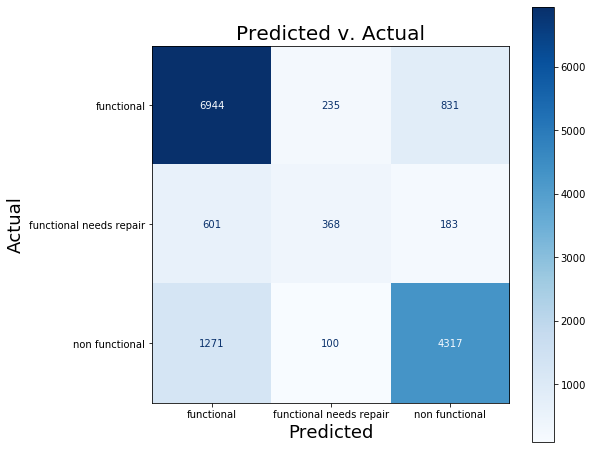

In [14]:
fig, ax= plt.subplots(figsize=(8,8))
plot_confusion_matrix(rfc, x_te_split, y_te_split, ax = ax, cmap=plt.cm.Blues)
plt.title('Predicted v. Actual', fontsize = 20)
ax.grid(False)
plt.xlabel('Predicted', fontsize = 18)
plt.ylabel('Actual', fontsize = 18)
plt.show()

We can see from this confusion matrix that our model is very bad at predicting 'functional needs repair'

### ***Random Forest Classifier***

lets try to improve our random forest by adjusting some of the hyper-parameters

In [16]:
rf_2=RandomForestClassifier(max_depth=25, max_features='sqrt', min_samples_split=7, n_estimators=200)
rf_2.fit(x_tr_split, y_tr_split['status_group'])
print(f'New random forest scored: {rfc.score(x_te_split, y_te_split)}')

New random forest scored: 0.7830976430976431


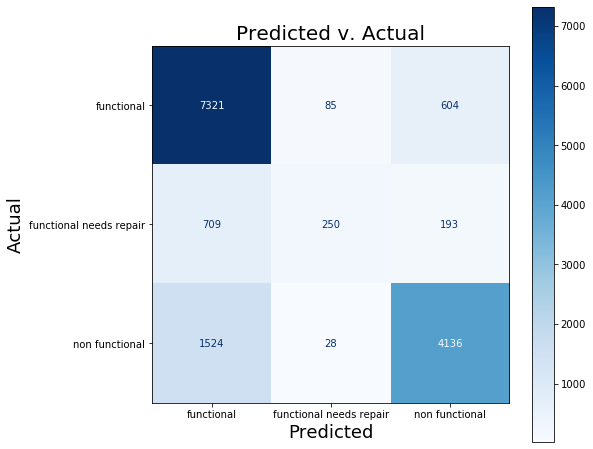

In [17]:
fig, ax= plt.subplots(figsize=(8,8))
plot_confusion_matrix(rf_2, x_te_split, y_te_split, ax = ax, cmap=plt.cm.Blues)
plt.title('Predicted v. Actual', fontsize = 20)
ax.grid(False)
plt.xlabel('Predicted', fontsize = 18)
plt.ylabel('Actual', fontsize = 18)
plt.show()

this model actually performs worse than our first simple model

### ***KNeighbor Classifier***

In [20]:
kn3_2 = KNeighborsClassifier(n_neighbors = 15)
kn3_2.fit(x_tr_split, y_tr_split['status_group'])
y_pred_kn3_2=kn3_2.predict(x_te_split)
print(classification_report(y_te_split, y_pred_kn3_2))

                         precision    recall  f1-score   support

             functional       0.75      0.87      0.81      8010
functional needs repair       0.55      0.24      0.33      1152
         non functional       0.78      0.70      0.74      5688

               accuracy                           0.75     14850
              macro avg       0.69      0.60      0.63     14850
           weighted avg       0.75      0.75      0.74     14850



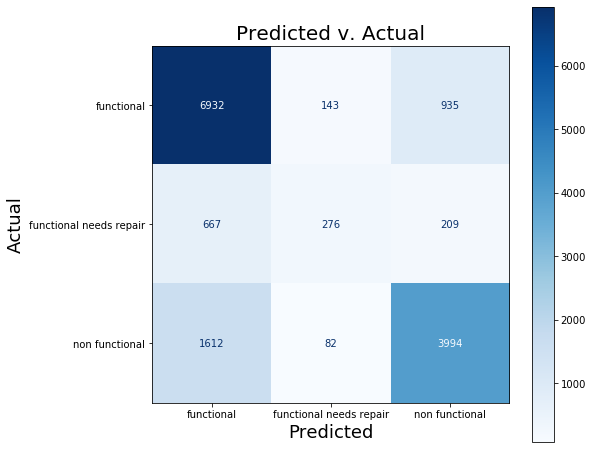

In [21]:
fig, ax= plt.subplots(figsize=(8,8))
plot_confusion_matrix(kn3_2, x_te_split, y_te_split, ax = ax, cmap=plt.cm.Blues)
plt.title('Predicted v. Actual', fontsize = 20)
ax.grid(False)
plt.xlabel('Predicted', fontsize = 18)
plt.ylabel('Actual', fontsize = 18)
plt.show()

In [24]:
#example of hypertuning, did not improve recall, only accuracy as may be expected
kn3_5 = KNeighborsClassifier(n_neighbors = 3, weights = 'distance', p = 1, algorithm = 'brute')
kn3_5.fit(x_tr_split, y_tr_split['status_group'])
y_pred_kn3_5=kn3_5.predict(x_te_split)
print(classification_report(y_te_split, y_pred_kn3_5))

                         precision    recall  f1-score   support

             functional       0.77      0.82      0.80      8010
functional needs repair       0.42      0.35      0.38      1152
         non functional       0.78      0.73      0.75      5688

               accuracy                           0.75     14850
              macro avg       0.66      0.63      0.64     14850
           weighted avg       0.75      0.75      0.75     14850



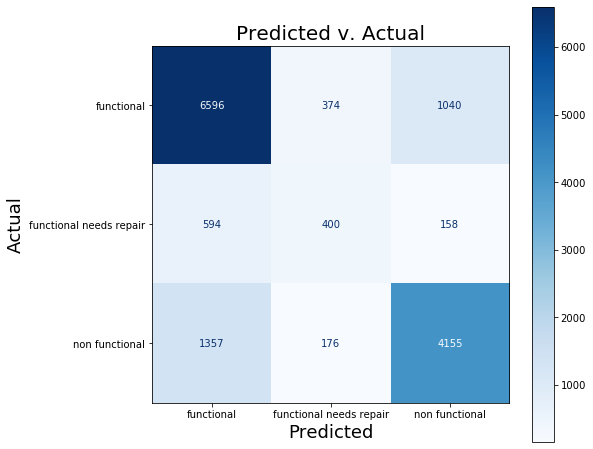

In [25]:
fig, ax= plt.subplots(figsize=(8,8))
plot_confusion_matrix(kn3_5, x_te_split, y_te_split, ax = ax, cmap=plt.cm.Blues)
plt.title('Predicted v. Actual', fontsize = 20)
ax.grid(False)
plt.xlabel('Predicted', fontsize = 18)
plt.ylabel('Actual', fontsize = 18)
plt.show()

## **Rethinking Our Classes**

After tesing various models and up-sampling techniques such as SMOTE, we were unable to reliably classify our minority class 'functional, needs repair'. Because of this we decided that the most important thing is to classify any well that needed repair and that combining 'functional, needs repair' and 'non-functional' would be an effective way to eliminate our minority class while still answering the fundamental question of which wells need repair and which wells are completely functional.

In [4]:
# creating a function that converts the 'functional' class to 1 and every other class to 0
bin_y = lambda x: 1 if x == 'functional' else 0
# apply the function to y_train and y_test
y_tr_binned = pd.DataFrame(y_tr_split['status_group'].apply(bin_y), index = y_tr_split.index, columns = y_tr_split.columns)
y_te_binned = pd.DataFrame(y_te_split['status_group'].apply(bin_y), index = y_te_split.index, columns = y_te_split.columns)

## **Final Model**

We came to our final model by grid searching with a random forest classifier. The best parameters found in the grid search were: max_features = 75, min_samples_leaf = 3, n_estimators = 200 

In [8]:
# creating a RandomForestClassifier object with our best parameters
final_model = RandomForestClassifier(max_features = 75, min_samples_leaf = 3, n_estimators = 200)

In [9]:
# Fitting our classifier on the training split
final_model.fit(x_tr_split, y_tr_split['status_group'])

RandomForestClassifier(max_features=75, min_samples_leaf=3, n_estimators=200)

In [10]:
# Scoring our model's accuracy on the testing split
final_model.score(x_te_split, y_te_split)

0.790976430976431

## **Conclusion**

Our final model was able to predict whether or not a well is in need of repair with an accuracy of 80.8%. The most important features in determining which class a well would fall into were the well altitude (gps_height in the data), the water point type, the contsruction year, and the size of the population that relies on that well. We think there is potential for improvement in our model by a small margin if we perhaps drop some of the least important features and adjust our pre-processing strategy to reduce data leakage, but we’ll likely only see a small increase in accuracy and recall as the data itself seems to have a significant bit of random noise.